In [2]:
curr_dir = f'/user_data/vayzenbe/GitHub_Repos/pepdoc' #CHANGE AS NEEEDED CAUSE ITS FOR VLAAAD

import sys
sys.path.insert(0,curr_dir)
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import scipy
import statsmodels.api as s
from sklearn import metrics

import pdb
import pepdoc_params as params

In [3]:
sub_list = params.sub_list
data_dir = params.data_dir
fig_dir = f'{curr_dir}/figures' #where to save the figures
results_dir = f'{curr_dir}/results' #where to save the results

#stim info
categories = params.categories
labels = params.labels

#channels of interest
channels = params.channels

#analysis window info
pre_stim = params.pre_stim
post_stim = params.post_stim
bin_size = params.bin_size
bin_length = params.bin_length

start_window = params.start_window
stim_onset = params.stim_onset
stim_offset = params.stim_offset
timepoints = params.timepoints

#### Granger causality

In [11]:
rois = [['dorsal','ventral'],['dorsal','ventral','frontal'],['dorsal','ventral','occipital']]


summary_df = pd.DataFrame()
for roi in rois:
    roi_cat = '_'.join(roi)

    curr_df = pd.read_csv(f'{results_dir}/mvgca/{roi_cat}.csv')
    summary_df[roi_cat] = curr_df['dorsal_ventral']

summary_df['sub'] = curr_df['sub']

#write to results
summary_df.to_csv(f'{results_dir}/mvgca/mvgca_summary.csv',index=False)







In [10]:
roi

['dorsal', 'ventral']

#### Time generalized RSA analyses

In [12]:
"""
Plot time generalization using mean RDMs
"""

rois = ['dorsal','ventral', 'frontal','occipital']
#rois = ['dorsal']

#timepoints = np.asanyarray(timepoints)
time_cols = np.asanyarray(timepoints)
time_cols[1:] = time_cols[1:]
for roi1 in rois:
    for roi2 in rois:
        plt.figure(figsize=(6, 6), dpi=80)
        corr_ts = np.load(f'{results_dir}/rsa/{roi1}_{roi2}_corr_ts.npy')
        
        corr_df = pd.DataFrame(corr_ts, columns = time_cols, index = time_cols)
        corr_df = corr_df.iloc[:stim_offset,:stim_offset]
        ax = sns.heatmap(corr_df,xticklabels=25,yticklabels=25, vmin = 0, vmax = 1, square = True,
            cmap= "rocket_r")
        #ax.set_title(f'{roi1} {roi2}')
        ax.invert_yaxis()
        plt.axvline(13,  linestyle='--', color = 'black')
        plt.axhline(13,  linestyle='--', color = 'black')
        plt.ylabel(roi1.capitalize(), fontsize=14)
        plt.xlabel(roi2.capitalize(), fontsize=14)
        #cbar = ax.collections[0].colorbar
        #cbar.ax.tick_params(labelsize=12)
        #cbar.ax.clabel

        #ax.set(xticklabels=[])

        #ax.tick_params(bottom=False)  # remove the ticks
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        plt.show()
        plt.savefig(f'{fig_dir}/{roi1}_{roi2}_time_generalization.png', dpi=300)
    

ValueError: Shape of passed values is (87, 87), indices imply (138, 138)

<Figure size 480x480 with 0 Axes>

In [20]:
"""
Time generalization diff on mean RDMs
"""

corr_ts = np.load(f'{results_dir}/rsa/dorsal_ventral_corr_ts.npy')
corr_ts = corr_ts[stim_onset:stim_offset,stim_onset:stim_offset]

corr_df = pd.DataFrame()
corr_df['corrs'] = corr_ts.flatten()

x_coord = []
y_coord = []
offset = []
label = []

inds = np.triu_indices(n=corr_ts.shape[0],k=1)
right_side = corr_ts[inds] #extract lower triangle
left_side = corr_ts[(inds[1],inds[0])] #extract upper triangle

for corr in corr_df['corrs']:
    if len(np.where(right_side == corr)[0]) == 1:
        label.append('Dorsal')
    if len(np.where(left_side == corr)[0]) == 1:
        label.append('Ventral')
    elif len(np.where(right_side == corr)[0]) == 0 and len(np.where(left_side == corr)[0]) == 0:
        label.append('Same')
    

    curr_x = np.where(corr_ts == corr)[0]
    curr_y = np.where(corr_ts == corr)[1]
    x_coord.append(curr_x)
    y_coord.append(curr_y)

    offset.append((curr_x- curr_y)*4)

corr_df['x_coord'] = x_coord
corr_df['y_coord'] = y_coord
corr_df['offset'] = offset
corr_df['label'] = label

corr_df.to_csv(f'{results_dir}/rsa/dorsal_ventral_corrs.csv')

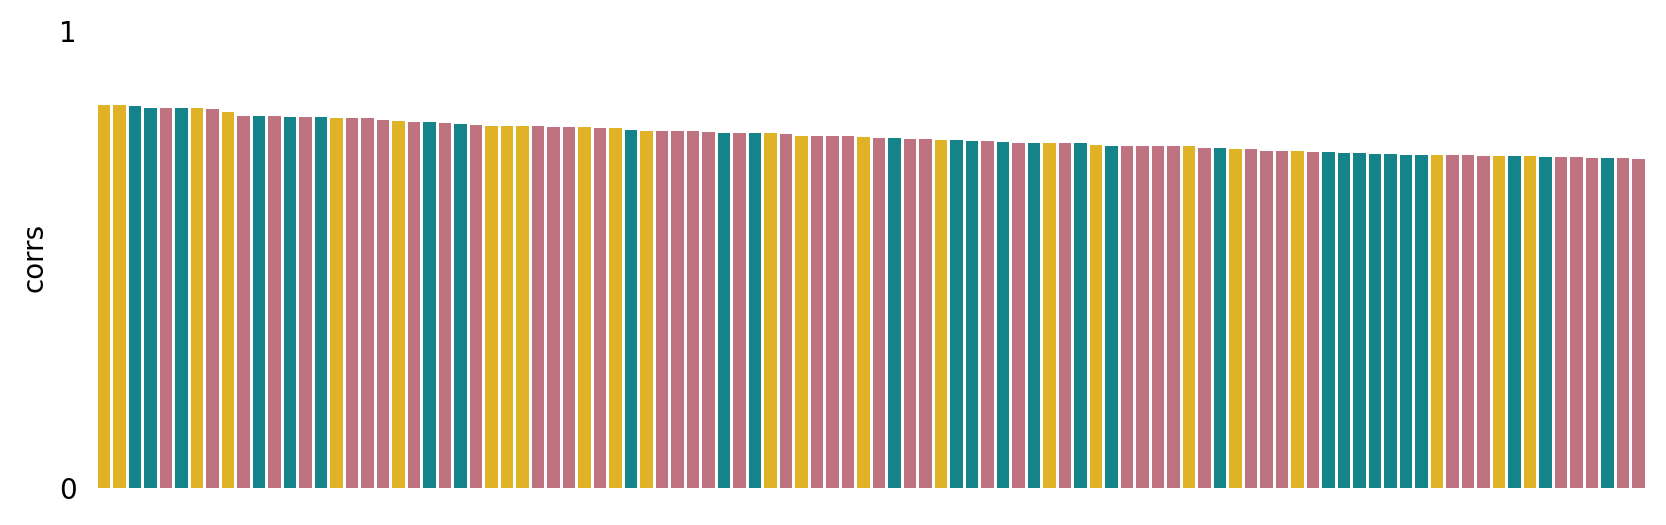

In [21]:
'''
Plot histogram of top correlations
'''
corr_df = pd.read_csv(f'{results_dir}/rsa/dorsal_ventral_corrs.csv')

corr_df = corr_df.sort_values(by='corrs', ascending=False)
corr_df = corr_df.reset_index()
hues = ['#FFC107','#CC6677','#00949e']

vals = 100
fig_df = corr_df.head(vals)

plt.figure(figsize=(10, 3), dpi=200)
sns.barplot(y=fig_df['corrs'], x = fig_df.index,order = fig_df.index, hue = fig_df['label'],dodge = False,
            palette = ['#FFC107','#00949e','#CC6677'])
ax = plt.gca()
ax.set(xticklabels=[])
ax.tick_params(bottom=False,left= False)  # remove the ticks
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)


#plt.ylabel('Correlation',fontsize=16)
#plt.axvline(onsets[roi[0]],  linestyle='--', color = colors[roi[0]])
#plt.yticks(np.arange(min(x), max(x)+1, 1.0))
#plt.xticks(fontsize= 14)
#plt.yticks(fontsize= 14)
plt.ylim(0,1.01)

ax = plt.gca()
#ax.xaxis.set_tick_params(width=1.5)
#ax.yaxis.set_tick_params(width=1.5)

start, end = ax.get_ylim()
ax.yaxis.set_ticks(np.arange(start, end, 1))

ax.get_legend().remove()


plt.savefig(f'{fig_dir}/correlation_hist_{vals}.png', dpi=300)

In [22]:
fig_df.groupby('label').count()

,index,Unnamed: 0,corrs,x_coord,y_coord,offset
label,,,,,,
Dorsal,47,47,47,47,47,47
Same,24,24,24,24,24,24
Ventral,29,29,29,29,29,29


In [8]:
vals = np.arange(50,2050,50)

for val in vals:
    fig_df = corr_df.head(val)

    time_count = np.sum(fig_df['label'] == 'Dorsal')

    print(f'{time_count} out of {val}', time_count/ val, stats.binom_test(time_count,n=val, p= 0.49, alternative='two-sided'))
    

24 out of 50 0.48 1.0
47 out of 100 0.47 0.7643078059842483
70 out of 150 0.4666666666666667 0.6242850942925785
95 out of 200 0.475 0.7237180864723418
119 out of 250 0.476 0.704361045432474
145 out of 300 0.48333333333333334 0.8624998917763698
165 out of 350 0.4714285714285714 0.5212207601817229
196 out of 400 0.49 1.0
219 out of 450 0.4866666666666667 0.9248848389327154
247 out of 500 0.494 0.8581570271143317
281 out of 550 0.5109090909090909 0.3270630483358239
306 out of 600 0.51 0.3274849392389615
343 out of 650 0.5276923076923077 0.05960452997882648
378 out of 700 0.54 0.009046684505977332
409 out of 750 0.5453333333333333 0.002722245598470577
437 out of 800 0.54625 0.001631674954734338
458 out of 850 0.5388235294117647 0.0048769377439409085
484 out of 900 0.5377777777777778 0.004571820478517383
516 out of 950 0.5431578947368421 0.0011630175022550233
543 out of 1000 0.543 0.0008878744553639138
564 out of 1050 0.5371428571428571 0.0024706586739111826
592 out of 1100 0.53818181818181

In [5]:
"""
Test whether **INDIV** RDMs are right shifted or left shifted
"""
rois = ['dorsal','ventral','frontal','occipital']


#timepoints = np.asanyarray(timepoints)
time_cols = np.asanyarray(timepoints)
time_cols[1:] = time_cols[1:] + 2



df = pd.DataFrame()
df['subs'] = sub_list
for roi1 in rois:
    for roi2 in rois:
        if roi1 == roi2:
            continue
        else:
            sub_diffs =[]
            for sub in sub_list:
                corr_ts = np.load(f'{data_dir}/{sub}_{roi1}_{roi2}_corr_ts.npy')
                corr_ts = corr_ts[stim_onset:stim_offset,stim_onset:stim_offset]

                #extract left and right sides of the diagnol
                inds = np.triu_indices(n=corr_ts.shape[0],k=1)
                right_side = corr_ts[inds] #extract lower triangle
                left_side = corr_ts[(inds[1],inds[0])] #extract upper triangle

                #calculate the difference between the left and right sides
                #if positive, then right shifted
                diff = right_side - left_side


                
                #left side rdm

                sub_diffs.append(np.mean(diff))

            df[f'{roi1}_{roi2}'] = sub_diffs


df.to_csv(f'{results_dir}/rsa/indiv_tga_diffs.csv', index = False)

### TGM partial! correlations

In [8]:
"""
Test whether **INDIV** partial RDMs are right shifted or left shifted
"""
rois = ['dorsal','ventral', 'frontal','occipital']
control_rois = ['occipital','frontal','dorsal','ventral']



#timepoints = np.asanyarray(timepoints)
time_cols = np.asanyarray(timepoints)
time_cols[1:] = time_cols[1:] + 2



df = pd.DataFrame()
df['subs'] = sub_list
for control_roi in control_rois:
    for roi1 in rois:
        for roi2 in rois:
            if roi1 == roi2:
                continue
            else:
                sub_diffs =[]
                for sub in sub_list:
                    if os.path.isfile(f'{data_dir}/{sub}_{roi1}_{roi2}_corr_ts_{control_roi}.npy'):
                        corr_ts = np.load(f'{data_dir}/{sub}_{roi1}_{roi2}_corr_ts_{control_roi}.npy')
                        corr_ts = corr_ts[stim_onset:stim_offset,stim_onset:stim_offset]

                        #extract left and right sides of the diagnol
                        inds = np.triu_indices(n=corr_ts.shape[0],k=1)
                        right_side = corr_ts[inds] #extract lower triangle
                        left_side = corr_ts[(inds[1],inds[0])] #extract upper triangle

                        #calculate the difference between the left and right sides
                        #if positive, then right shifted
                        diff = right_side - left_side


                        
                        #left side rdm

                        sub_diffs.append(np.mean(diff))

                df[f'{roi1}_{roi2}_{control_roi}'] = sub_diffs


df.to_csv(f'{results_dir}/rsa/indiv_tga_partial_diff.csv', index = False)

In [11]:
sub_diffs

[]